Group Memebers

*   Chirag Gupta - 10623123
*   Chukwuebuka Uwaoma - 10621864
*   Dipanshu



In [113]:
# Import necesarry libraries
import tweepy
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import mysql.connector
from datetime import datetime
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sqlalchemy import create_engine


In [114]:
# Load dotenv and read tokens and enviroment variables from .env file
load_dotenv()
api_key = os.getenv('api_key')
api_secret_key = os.getenv('api_secret_key')
access_token = os.getenv('access_token')
access_token_secret = os.getenv('access_token_secret')

In [115]:
# Connect to twitter using tweepy API and stored tokens
auth = tweepy.OAuthHandler(api_key,api_secret_key)
auth.set_access_token(access_token,access_token_secret)
api = tweepy.API(auth)

In [116]:
# Pulls tweets based on search query and geocode location
tweetlist = []
geocode="53.1424,-7.6921,300km" 
filter =  '-filter:retweets AND -filter:replies'
query = 'housing'
tweets = tweepy.Cursor(api.search_tweets, q=query+filter, geocode=geocode, lang='en', tweet_mode="extended", count=200).items()

# adds tweets to a dataframe
column_names = ["id", "created_at", "username", "tweet", "retweet_count", "favorite_count", "user_location"]
df = pd.DataFrame(columns=column_names)

for tweet in tweets:
    #create a new row object
    new_row = pd.Series({
        "id": tweet.id, 
        "created_at":tweet.created_at,
        "username": tweet.user.screen_name, 
        "tweet": tweet.full_text, 
        "retweet_count": tweet.retweet_count, 
        "favorite_count": tweet.favorite_count,
        "user_location":tweet.user.location,
    })
    
    # get the index of the last row
    last_row_index = len(df)
    # add the new row to the DataFrame using .iloc[]
    df.loc[last_row_index] = new_row
df.head()

sum(df.duplicated())

0

In [118]:
# Pre-processing the data

# Formatting the date to dd/mm/YYYY format
def formatDate(timestamp):
    # As the timestamp retrieved from the api is already in DatetimeIndex form, simply running string format function 
    # of the datetime library and passing the desired format
    formatted_date = timestamp.strftime("%Y/%m/%d")
    return formatted_date

# Getting only the words and numbers from the tweet that contains links, special symbols, emojis, etc.
def cleanTweet(tweet):
    # Converting the string to lowercase and replacing the ' with blank
    removed_apostrophe = tweet.lower().replace("'","")
    # Using regex pattern to replace the links, <html> tags and &amp; symbol (seen frequently in the tweets) with blank
    removed_links_tags_frequentsymbol = re.sub("(https?://\S+)|(<[\w]+>)|(&amp;)","",removed_apostrophe)
    # This regex pattern returns a list that contains all the words and numbers in the tweet
    cleaned_tweet = re.findall("([a-z0-9]+)", removed_links_tags_frequentsymbol)
    cleaned_tweet = " ".join(cleaned_tweet)
    return cleaned_tweet

# Applying respective functions to both columns in the dataset
df["created_at"] = df["created_at"].apply(lambda x: formatDate(x))
df["tweet"] = df["tweet"].apply(lambda x: cleanTweet(x))
df.head()

0

In [119]:
connection = mysql.connector.connect(host='localhost',
                                    database='ca',
                                    user='root',
                                    password='root')

In [120]:
# SQL query to create a table and inserting the columns name in it.
mySql_insert_query = 'CREATE TABLE if not exists api (id int(22) primary key ,created_at DATE, \
                    username varchar(255),tweet TEXT(300),retweet_count INT,favorite_count INT, user_location varchar(255));'

In [121]:
# Create a cursor object "cursor" to execute MySQL queries with.
# The "buffered=True" parameter sets up the cursor to buffer the results, which can be useful for large queries.
cursor = connection.cursor(buffered=True)

# Use the cursor's "execute()" method to execute the MySQL query specified in the "mySql_insert_query" variable.
cursor.execute(mySql_insert_query)

# Commit the changes made to the MySQL database using the connection's "commit()" method.
connection.commit()

In [122]:
engine = create_engine(os.getenv('db_string'))
df.to_sql('api', con = engine, if_exists = 'replace',index = False, chunksize = 1000)

975

In [123]:
# Data retrieve from DB and insert into pd df

# Define a MySQL query "sql_query" to select all columns from the "api" table.
sql_query = "SELECT * FROM api"

# Use the cursor's "execute()" method to execute the MySQL query.
cursor.execute(sql_query)

# Use the cursor's "fetchall()" method to fetch all the rows returned by the MySQL query.
result = cursor.fetchall()

# Convert the fetched rows into a Pandas DataFrame "data" using the "pd.DataFrame()" function.
data=pd.DataFrame(result)

# Rename the columns of the DataFrame using the "columns" attribute of the DataFrame.
data.columns=["id", "created_at", "username", "tweet", "retweet_count", "favorite_count", "user_location"]

# Print the DataFrame "data" to the console.
data.head()



,id,created_at,username,tweet,retweet_count,favorite_count,user_location
970,1645790939485712387,2023/04/11,votemaryfitz,do you know what a cost rental home is apply f...,4,16,"Dublin, Ireland"
971,1645787063546163204,2023/04/11,amonsterd,these targets would be impressive if multiplie...,0,0,"Dalkey, Co. Dublin"
972,1645785884040769539,2023/04/11,meathcoco,update 11th april 2023 a reminder that afforda...,0,0,"Meath, Ireland"
973,1645783842429755397,2023/04/11,kvn_clmn,same in ireland there is a huge ideal put on h...,0,3,"Tipperary, Ireland"
974,1645781316137525248,2023/04/11,PropDistrict,conservation is an obstacle to housing crisis ...,0,0,Dublin & Galway


In [124]:
# Download necessary resources from NLTK
# Lemmatize tweet words to base words
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def lemmatize_tweet(tweet):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(tweet)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word) for word in tokens])
    return lemmatized_sentence

data['lemmatize_tweet'] = df['tweet'].apply(lemmatize_tweet)

[nltk_data] Downloading package punkt to /Users/dbs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dbs/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/dbs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [125]:
def get_county(location):
    # returns the county from the users location
    if location is None:
        return 'Other'
    if 'dublin' in location.lower():
        return 'Dublin'

    split = location.split(',')
    if len(split) > 2:
        return split[1].strip() 
    elif len(split) > 1:
        return split[0].strip() 
    else:
        if split[0].lower() != "ireland":
            return split[0].strip() 
        else: return 'Other'

data['user_location'] = df['user_location'].apply(get_county)
data.head()


,id,created_at,username,tweet,retweet_count,favorite_count,user_location,lemmatize_tweet
0,1649385890538737664,2023/04/21,ClareFM,clare recruiter warns housing shortage is crea...,0,0,Co. Clare,clare recruiter warns housing shortage creatin...
1,1649383118963449863,2023/04/21,Ferm_Herald,wheres my heating dying man slams housing exec...,0,0,Enniskillen,wheres heating dying man slam housing executiv...
2,1649382784950059009,2023/04/21,GravisPlanning,last month we in partnership with studiorogers...,1,1,UK & Ireland,last month partnership studiorogers delighted ...
3,1649377688111525888,2023/04/21,UTVNews,utv is looking to speak to people ahead over 6...,0,1,Belfast,utv looking speak people ahead experiencing lo...
4,1649377086920949761,2023/04/21,Garymc1967,for me this is what being an elected rep is al...,0,2,Glenavy,elected rep weather issue health education inf...


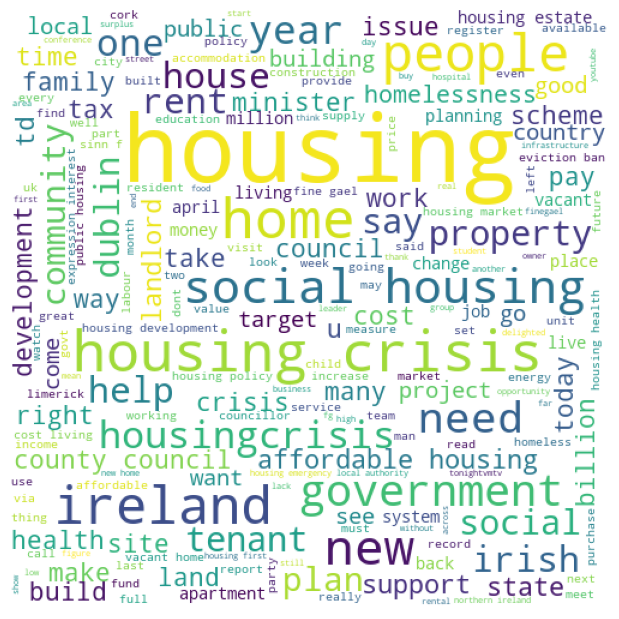

In [136]:
# Visualize wordcloud for all tweets for most occuring words

# Concatenate all tweets into a single string
all_tweets = ' '.join(data['lemmatize_tweet'])

# Generate a word cloud from the concatenated string
wordcloud = WordCloud(width=500, height=500, background_color='white').generate(all_tweets)

# Display the word cloud
plt.figure(figsize=(6, 6), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

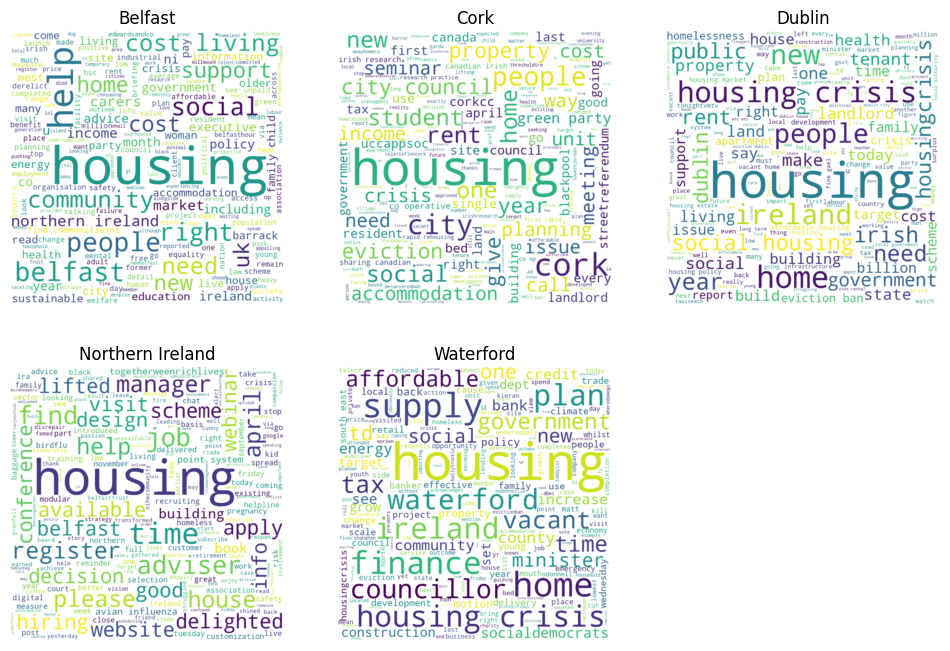

In [133]:
# Visualize wordcloud for top 5 county's by tweets

location_counts = data['user_location'].value_counts()
top_locations = location_counts[:5].index.tolist()
location_df = data[data['user_location'].isin(top_locations)].copy()

# Group the filtered DataFrame by location
grouped_data = location_df.groupby('user_location')['lemmatize_tweet'].apply(lambda x: ' '.join(x)).reset_index()
grouped_data = grouped_data.head(5)

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs[1][2].set_visible(False)

# Create a word cloud for each location and plot it in the corresponding subplot
for i, row in grouped_data.iterrows():
    location = row['user_location']
    text = row['lemmatize_tweet']
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
    ax = axs[i // 3, i % 3]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(location)
    ax.axis('off')
    
# Show the plot
plt.show()


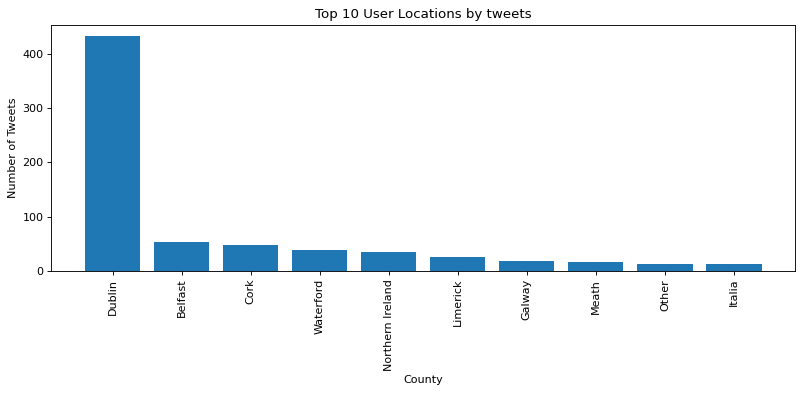

In [129]:
location_counts = data['user_location'].value_counts().nlargest(10)
from matplotlib.pyplot import figure

figure(figsize=(12, 4), dpi=80)

plt.bar(location_counts.index, location_counts.values)
plt.title('Top 10 User Locations by tweets')
plt.xlabel('County')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)
plt.show()